In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import nest
import numpy as np
import os

from pynestml.frontend.pynestml_frontend import generate_nest_target

NEST_SIMULATOR_INSTALL_LOCATION = nest.ll_api.sli_func("statusdict/prefix ::")

<frozen importlib._bootstrap>:241: RuntimeWarning: compiletime version 3.8 of module 'pynestkernel' does not match runtime version 3.1
<frozen importlib._bootstrap>:241: RuntimeWarning: builtins.type size changed, may indicate binary incompatibility. Expected 880 from C header, got 888 from PyObject



              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: master@61f08e0ea
 Built: Jul 14 2022 17:28:07

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [2]:
kernel = "exp" # psc kernel "alpha" or "exp"

neuron_model = [
    "edlif_psc_"+kernel+"_percent.nestml",
    "iaf_psc_"+kernel+".nestml"
]
# if any model is not working:
# rebuild in EDLIF_two_neuron_example.ipynb
# 

# Choose noise type
noise = "poisson_generator" # noise_generator (gaussian) or poisson_generator
# more info here:
# https://nest-simulator.readthedocs.io/en/v2.18.0/models/generator.html#classnest_1_1ac__generator
exc_mean = 100 # mean value of noise current (pA). Only for Gaussian
exc_std = exc_mean/10
inh_mean = 100
inh_std = inh_mean/10
exc_rate = 100000*0.1 # Only for poisson
inh_rate = 100000

# weights
noise_exc_w = 1.*2
noise_inh_w = -1.*0

# neuron params
th = -55 # default value: -55
t_ref = 6
tau_syn_exc = 12

# seed
seed = 1

# sim time
sim_time = 600

In [3]:
def try_install_module(module_name):
    try:
            nest.Install(module_name)
            nest.Create(neuron_model[0].split(".")[0])
    except:
        generate_nest_target(input_path=neuron_model[0],
                     target_path="/tmp/nestml-component",
                     module_name=module_name,
                     logging_level="INFO",
                     codegen_opts={"nest_path": NEST_SIMULATOR_INSTALL_LOCATION})
        nest.ResetKernel()
        nest.Install(module_name)

if neuron_model[0]=="edlif_psc_exp_percent.nestml":
    module_name = "edlif_psc_exp" + "_module"
    try_install_module(module_name)
else:
    module_name = "edlif_psc_alpha" + "_module"
    try_install_module(module_name)


Sep 02 18:10:17 Install [Info]: 
    loaded module edlif_psc_exp_module


In [4]:
def bombard_neuron(neuron_id, seed):
    nest.ResetKernel()
    nest.rng_seed = seed
    neuron_model_name = neuron_model[neuron_id].split(".")[0]
    print(f"Using neuron model: {neuron_model_name}")

    neuron = nest.Create(neuron_model_name)
    # neuron params
    if th != -55:
        if neuron_model_name=="iaf_psc_exp":
            neuron.V_th = th
        else:
            neuron.V_th = th
            neuron.ATP = 90
    neuron.t_ref = t_ref
    neuron.tau_syn_ex = tau_syn_exc

    exc_noise = nest.Create(noise)
    inh_noise = nest.Create(noise)
    mult = nest.Create("multimeter", params={'record_from':['V_m']})
    sr = nest.Create('spike_recorder')
    


    if noise == "noise_generator":
        exc_noise.mean = exc_mean
        exc_noise.std = exc_std
        inh_noise.mean = inh_mean
        inh_noise.std = inh_std
    elif noise == "poisson_generator":
        exc_noise.rate = exc_rate  
        inh_noise.rate = inh_rate  
    
    # connections
    syn_dict_noise_exc = {"weight": noise_exc_w}
    syn_dict_noise_inh = {"weight": noise_inh_w}
    nest.Connect(exc_noise, neuron, syn_spec=syn_dict_noise_exc)
    nest.Connect(inh_noise, neuron, syn_spec=syn_dict_noise_inh)

    nest.Connect(mult, neuron)
    nest.Connect(neuron, sr)
    nest.Simulate(sim_time)

    vm = mult.get('events', 'V_m')
    spk_times = sr.get('events', 'times')
    
    print(neuron)
    print(type(neuron))
    
    return vm, spk_times 

In [5]:
def plot_vm(vm, s_times):
    plt.figure(figsize=(12, 6))
    #fig, ax = plt.subplots(nrows=2, figsize=(15,12))
    plt.plot(vm, label="voltage")
    spks = np.ones(len(s_times))*-50
    plt.plot(s_times, spks, 'o', color='orange', label="spike times")
    plt.xlabel('time (ms)')
    plt.ylabel('Voltage (mV)')
    plt.legend()

Using neuron model: edlif_psc_exp_percent

NodeCollection(metadata=None, model=edlif_psc_exp_percent, size=1, first=1)Sep 02 18:10:17 NodeManager::prepare_nodes [Info]: 
    Preparing 5 nodes for simulation.

Sep 02 18:10:17 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 5
    Simulation time (ms): 600
    Number of OpenMP threads: 1
    Not using MPI

Sep 02 18:10:17 SimulationManager::run [Info]: 
    Simulation finished.

<class 'nest.lib.hl_api_types.NodeCollection'>


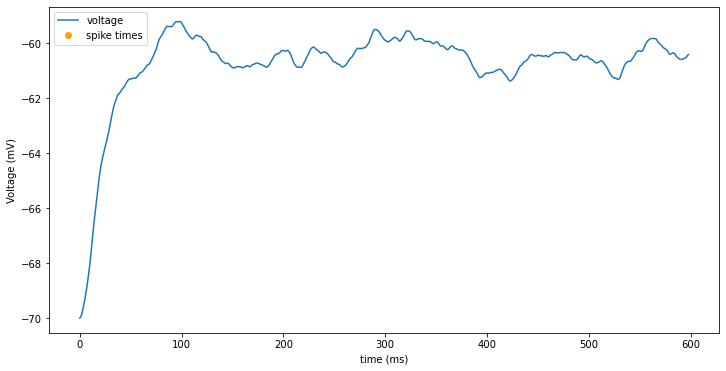

In [6]:
# Choose neuron model
neuron_id = 0 # edlif (0) or iaf (1)
vm_edlif, s_times_edlif = bombard_neuron(neuron_id, seed)
plot_vm(vm_edlif, s_times_edlif)

Using neuron model: iaf_psc_exp

Sep 02 18:10:18 NodeManager::prepare_nodes [Info]: 
NodeCollection(metadata=None, model=iaf_psc_exp, size=1, first=1)
<class 'nest.lib.hl_api_types.NodeCollection'>
    Preparing 5 nodes for simulation.

Sep 02 18:10:18 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 5
    Simulation time (ms): 600
    Number of OpenMP threads: 1
    Not using MPI

Sep 02 18:10:18 SimulationManager::run [Info]: 
    Simulation finished.


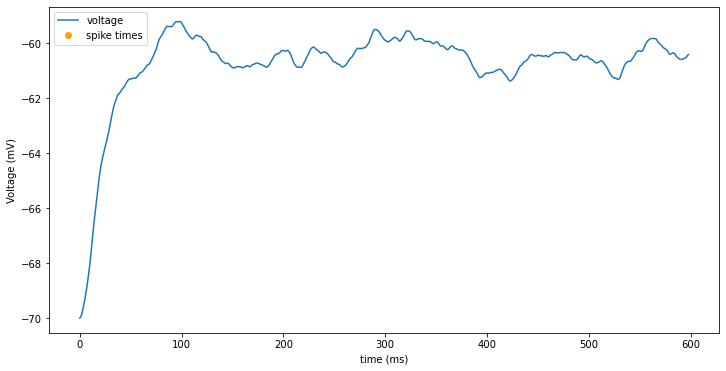

In [7]:
# Choose neuron model
neuron_id = 1 # edlif (0) o iaf (1)
vm_lif, s_times_lif = bombard_neuron(neuron_id, seed)
plot_vm(vm_lif, s_times_lif)

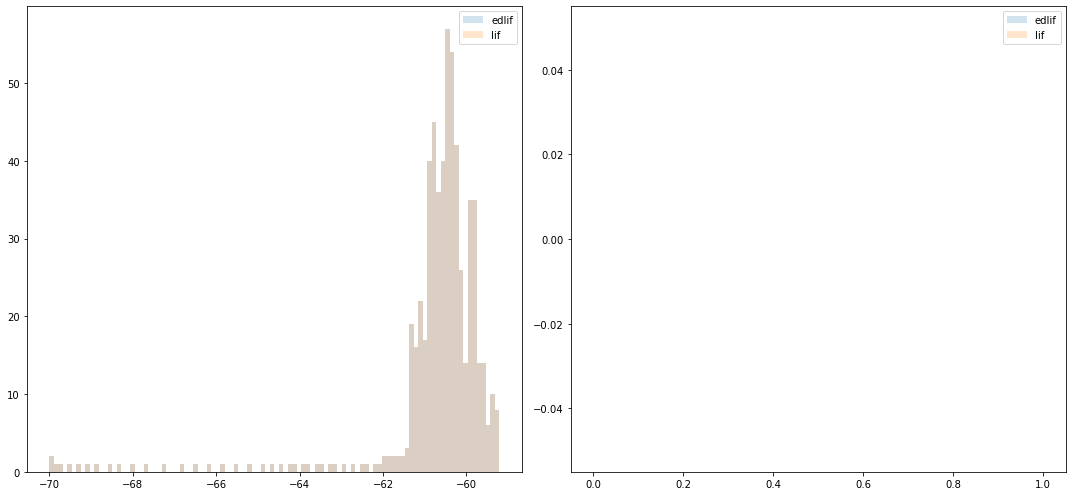

In [8]:
alpha = 0.2
n_bins = 100
def plot_hist(vm_edlif, vm_lif, isi_edlif, isi_lif):
    fig, ax = plt.subplots(1, 2,
                            figsize =(15, 7),
                            tight_layout = True)
    ax[0].hist(vm_edlif, bins=n_bins, alpha=alpha, label="edlif")
    ax[0].hist(vm_lif, bins=n_bins, alpha=alpha, label="lif")

    ax[1].hist(isi_edlif, bins=n_bins, alpha=alpha, label="edlif")
    ax[1].hist(isi_lif, bins=n_bins, alpha=alpha, label="lif")

    for x in ax:
        x.legend()
        
isi_edlif = s_times_edlif[1:] - s_times_edlif[:-1]
isi_lif = s_times_lif[1:] - s_times_lif[:-1]
plot_hist(vm_edlif, vm_lif, isi_edlif, isi_lif)

In [9]:
print(s_times_lif)
print(isi_lif)

[]
[]


In [10]:
neuron

NameError: name 'neuron' is not defined

In [ ]:
beta = 1
a = nest.random.exponential(beta)
print(a)